# Clustering
Created by: Juneyong Yang
Contact: laoconeth@kaist.ac.kr

## Preliminaries

앞으로 사용하게 될 library들 및 함수들이 선언된 곳입니다.


In [1]:
import sys
print(sys.version)

3.6.2 (default, May 30 2018, 21:53:12) 
[GCC 5.4.0 20160609]


In [2]:
import numpy as np
import sklearn.covariance
import sklearn.mixture
import sklearn.cluster
import torch
import math
import os
import time
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
def plot_data(X, y, n_clusters):
    # plot data
    plt.figure()

    for idx in range(n_clusters):
        plt.scatter(X[y == idx, 0], X[y == idx, 1],
                    label='{0}'.format(idx))


    ax = plt.gca()
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    plt.legend()
    plt.show()
    plt.close()


## Data
실습을 위해 인공 데이터를 생성합니다. 인공 데이터는 Gaussian Mixture로부터 만들어집니다. 먼저 클러스터의 개수를 정하고, 그 개수만큼 클러스터 평균(중심)을 샘플링합니다. 그 다음, 클러스터 별로 각각 Covariance Matrix를 샘플링합니다. 샘플링한 parameter들을 사용하여 실제 data point들을 샘플링하여 데이터셋을 생성합니다.

class mean:[-0.11142111  0.17036297]
covariance matrix:
[[0.09026703 0.036085  ]
 [0.036085   0.05024832]]
class mean:[-0.33740451  0.95899592]
covariance matrix:
[[ 0.06197379 -0.01561163]
 [-0.01561163  0.08802785]]
class mean:[ 0.90234619 -0.19326141]
covariance matrix:
[[0.03573143 0.04845437]
 [0.04845437 0.09278086]]
class mean:[0.81695713 0.83334083]
covariance matrix:
[[ 0.11776497 -0.03134708]
 [-0.03134708  0.01092163]]


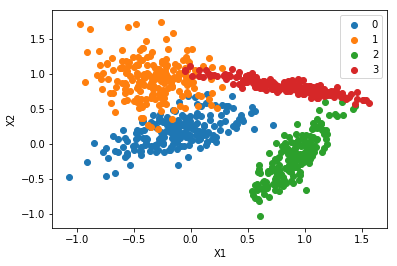

In [4]:
# Synthesize data

n_clusters = 4

mean_max = 3

X = []
y = []

for idx in range(n_clusters):
    coord = (int(idx / int(n_clusters**(1/2))), idx % int(n_clusters**(1/2)))
    class_mean = np.random.multivariate_normal(coord, cov=(np.eye(2)*0.02))
    print('class mean:{0}'.format(class_mean))
    A = np.random.uniform(-1, 1, (2, 2)) * 0.3
    real_cov = np.dot(A,A.transpose())
    print('covariance matrix:\n{0}'.format(real_cov))
    
    X.append(np.random.multivariate_normal(mean=class_mean, cov=real_cov, size=200))
    y.append(np.full(200, idx))
    
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

y_true = y

y_onehot = np.zeros((X.shape[0], 4))
y_onehot[np.arange(X.shape[0]), y] = 1



# plot data
plot_data(X, y_true, 4)




## K-Means

### Cluster assignment
데이터 $\left\{\mathbf{x}_{1}, \mathbf{x}_{2}, \mathbf{x}_{N}\right\}$ 을 받고, 모든 데이터 포인트를 K개의 그룹에 배정합니다.
클러스터 소속은 현재 데이터 포인트로부터 어떤 클러스터 중심이 가장 가까운지를 비교해본 후, 가장 가까운 클러스터에 배정합니다. 이때, "가까움" 은 유클리드 공간에서의 거리를 사용합니다. 즉, 
$$ r_{nk}=\begin{cases}
    1, & {\arg\min_{j} \|\mathbf{x}_{n} - \boldsymbol{\mu}_{j}\|_{2}^{2}}\\
    0, & \text{otherwise.}
  \end{cases}$$
  
### Cluster mean update
위에서와 같이 클러스터 소속을 배정한 후, 배정한 소속이 마치 진실이라고 가정하고 클러스터 중심을 계산합니다. 즉,
$$
\mu_{k}^{new} = \frac{\sum_{n}^{N} r_{nk}\mathbf{x}_{n}}{\sum_{n}^{N} r_{nk}}
$$

### Termination
위의 2가지 스텝을 반복하다 보면, 어느 순간부터는 더 반복해도 클러스터 배정이 바뀌지 않습니다. 클러스터 배정이 바뀌지 않는다면 클러스터 중심도 움직이지 않으므로, 알고리즘이 수렴한 것입니다. 따라서 종료할 수 있습니다.

In [29]:
def kMeans(X, n_clusters, max_iter = 10, verbose=False):

    centroids = X[np.random.choice(np.arange(len(X)), n_clusters), :]

    for i in range(max_iter):
        print('iter: {0}'.format(i))
        # Re-assign clusters
        y = np.array([np.argmin([np.dot(x_i-mu_k, x_i-mu_k) for mu_k in centroids]) for x_i in X])
        if i != 0:
            if np.array_equal(y,y_old):
                break
        y_old = y
        # Recalculate cluster means
        centroids = [X[y == k].mean(axis = 0) for k in range(n_clusters)]
         
    return np.array(centroids) , y

In [30]:
centroids, C = kMeans(X, n_clusters=4, verbose=True)

iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6


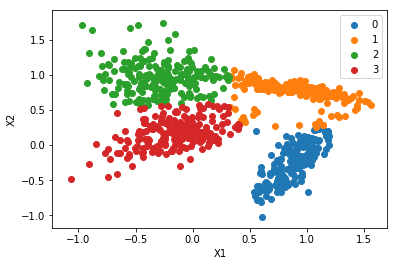

In [31]:
plot_data(X, C, 4)

### Using Prepackaged Libraries
우리의 코드가 잘 동작했는지 보기 위해 Scikit-Learn에 미리 구현되어 있는 K-mean 알고리즘을 사용합니다.

In [32]:
kmeans = sklearn.cluster.KMeans(n_clusters=4, init='random',  random_state=0).fit_predict(X)

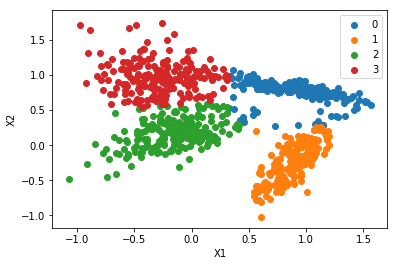

In [33]:
plot_data(X, kmeans, 4)

## Expectation Maximization
Total log likelihood:
$$
p(\mathbf{x}, \mathbf{z}|\pi, \mu, \Sigma) = \prod_{n=1}^{N}(\prod_{k=1}^{K}\pi_{k}^{z_{nk}} \mathcal{N}(x_{n}|\mu_{k}, \Sigma_{k})^{z_{nk}})
$$

E-Step에서는 추산된 클러스터들의 평균 $\mu_{k}$와 covariance matrix $\Sigma_{k}$들과 데이터 $x_{n}$을 사용하여, $x_{n}$이 과연 어떤 클러스터 소속일지 추론합니다. $x_{n}$이 클러스터 k에 속할 확률(responsibility) $r(z_{nk})$ 를 계산하는 것입니다.

$$
\begin{align} r(z_{nk}) &= p(z_{nk} = 1|x_{n}, \theta_{old}) \nonumber \\
&= \frac{\pi_{k}\mathcal{N}(x_{n}|\mu_{k}, \Sigma_{k})}{\sum_{j=1}^{K} \pi_{j}\mathcal{N}(x_{n}|\mu_{j}, \Sigma_{j})} \nonumber\\
\nonumber
\end{align}
$$

M-step에서는 E-step에서 추론한 responsibility를 진실이라고 믿고, 이로부터 Gaussian Mixture의 parameter들을 추정합니다.

$$
\pi_{k}^{new} = \frac{N_{k}}{N}
$$

$$
\mu_{k}^{new} = \frac{1}{{N_{k}}} \sum_{n}^{N} r(z_{nk})\mathbf{x}_{n}
$$

$$
\Sigma_{k}^{new} = \frac{1}{{N_{k}}} \sum_{n}^{N} r(z_{nk})(f(\mathbf{x}_{n}) - \bar{\mu_{k}})(f(\mathbf{x}_{n}) - \bar{\mu_{k}})^{T}
$$

E-step과 M-step을 계속 반복합니다. Likelihood가 더이상 상승하지 않거나, parameter들의 수렴 추세가 일정 threshold 미만으로 떨어졌다면, 알고리즘을 종료합니다.

In [34]:
def m_step(X, r):

    nClasses = r.shape[1]
    nSamples = r.shape[0]

    # compute class marginals
    class_marginals = np.sum(r, 0) / float(nSamples)

    # total data format: num_samples x features
    # posterior(patient_classes) format: num_samples x n_labels

    group_lasso = sklearn.covariance.EmpiricalCovariance(assume_centered=False)

    sample_class_mean = []
    out_count = 0
    
    num_features = X.shape[1]
    
    sample_class_mean = np.empty((nClasses, int(num_features)))
    sample_class_covariance = np.empty((nClasses, int(num_features), int(num_features)))
    for k in range(nClasses):
        Nk = np.sum(r[:, k])
        sample_class_mean[k] = np.sum(r[:, k:k+1] * X, 0) / Nk
        
        weighted_X = (X - sample_class_mean[k]) * np.sqrt(r[:, k:k+1])
        sample_class_covariance[k] = np.dot(weighted_X.T, weighted_X) / Nk

    return class_marginals, sample_class_mean, sample_class_covariance

In [35]:
from scipy.stats import multivariate_normal
def e_step(class_marginals, mean, covariance, X, y):
    # calculate w_j^{(i)}
    
    r = np.zeros(y.shape)
    
    for i in range(X.shape[0]):
        evidence = 0
        for j in range(y.shape[1]):
            joint_likelihood = multivariate_normal.pdf(X[i, :], 
                                                       mean[j], 
                                                       covariance[j]) * class_marginals[j]
            evidence += joint_likelihood
            r[i, j] = joint_likelihood
        r[i, :] /= evidence
        assert r[i, :].sum() - 1 < 1e-4
    return r

In [36]:
tol=0.00001
max_iter=100
init='average'

# initialize assignments
r = kmeans
r = np.zeros((X.shape[0], 4))
r[np.arange(X.shape[0]), kmeans] = 1


# initialize
iter = 0
converged = False
old_class_marginals = None
old_error_rates = None


(800, 4)
Iter	log-likelihood	delta-CM	delta-ER


In [37]:
print("Iter\tlog-likelihood\tdelta-CM\tdelta-ER")
while not converged:     
    iter += 1

    # M-step
    (class_marginals, sample_class_mean, sample_class_covariance) = m_step(X, r)        

    # E-step
    r = e_step(class_marginals, sample_class_mean, sample_class_covariance, X, y_onehot)  

    # check likelihood
    # log_L = calc_likelihood(counts, class_marginals, error_rates)
    log_L = 0

    if old_class_marginals is not None:
        class_marginals_diff = np.sum(np.abs(class_marginals - old_class_marginals))
        sample_class_mean_diff = np.sum(np.abs(sample_class_mean - old_sample_class_mean))
        sample_class_covariance_diff = np.sum(np.abs(sample_class_covariance - old_sample_class_covariance))
        print(
            '{0} \t {1} \t{2:.6f}\t{3:.6f}\t{4:.6f}'.format(iter,
                                                            log_L,
                                                            class_marginals_diff,
                                                            sample_class_mean_diff,
                                                            sample_class_covariance_diff))
        if (class_marginals_diff < tol
            and sample_class_mean_diff < tol
            and sample_class_covariance_diff < tol) or iter > max_iter:
            converged = True
    else:
        print('{0} \t {1}'.format(iter, log_L,))

    # update current values
    old_class_marginals = class_marginals
    old_sample_class_mean = sample_class_mean
    old_sample_class_covariance = sample_class_covariance

1 	 0
2 	 0 	0.024639	0.124531	0.092390
3 	 0 	0.008781	0.078757	0.051365
4 	 0 	0.006735	0.041280	0.025036
5 	 0 	0.005385	0.022053	0.014349
6 	 0 	0.004253	0.012833	0.008922
7 	 0 	0.003381	0.008599	0.006039
8 	 0 	0.002712	0.006565	0.004303
9 	 0 	0.002194	0.005163	0.003173
10 	 0 	0.001788	0.004136	0.002464
11 	 0 	0.001460	0.003328	0.001932
12 	 0 	0.001194	0.002691	0.001525
13 	 0 	0.000980	0.002185	0.001213
14 	 0 	0.000805	0.001781	0.000971
15 	 0 	0.000662	0.001456	0.000782
16 	 0 	0.000546	0.001193	0.000633
17 	 0 	0.000450	0.000980	0.000515
18 	 0 	0.000372	0.000806	0.000420
19 	 0 	0.000307	0.000664	0.000344
20 	 0 	0.000254	0.000548	0.000282
21 	 0 	0.000210	0.000452	0.000232
22 	 0 	0.000173	0.000373	0.000191
23 	 0 	0.000143	0.000308	0.000157
24 	 0 	0.000119	0.000255	0.000130
25 	 0 	0.000098	0.000211	0.000107
26 	 0 	0.000081	0.000175	0.000089
27 	 0 	0.000067	0.000144	0.000073
28 	 0 	0.000056	0.000120	0.000061
29 	 0 	0.000046	0.000099	0.000050
30 	 0 	0.000038	0.000

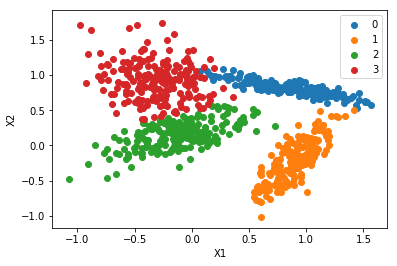

In [38]:
plot_data(X, np.argmax(r, axis=1), 4)

### Using Prepackaged Libraries
우리의 코드가 잘 동작했는지 보기 위해 Scikit-Learn에 미리 구현되어 있는 Gaussian Mixture 모델을 사용합니다.

sklearn.mixture.GaussianMixture(n_components=1,
                                covariance_type=’full’,
                                tol=0.001,
                                reg_covar=1e-06,
                                max_iter=100,
                                n_init=1,
                                init_params=’kmeans’,
                                weights_init=None,
                                means_init=None,
                                precisions_init=None,
                                random_state=None,
                                warm_start=False,
                                verbose=0,
                                verbose_interval=10)

In [39]:
gmm_model = sklearn.mixture.GaussianMixture(n_components=4,
                                            covariance_type='full',
                                            max_iter=100,
                                            n_init=1,
                                            init_params='kmeans',
                                            random_state=None,
                                            warm_start=False,
                                            verbose=0,
                                            verbose_interval=10)

In [40]:
y_prediction = gmm_model.fit_predict(X)

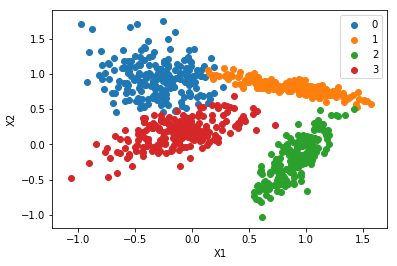

In [41]:
plot_data(X, y_prediction, 4)